In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft2, ifft2
from math import log10, sqrt
from scipy.optimize import minimize
from scipy.ndimage import sobel
from scipy.signal import convolve2d, deconvolve
from scipy.signal import fftconvolve

In [ ]:
img = cv2.imread("/content/happy dog.jpg")

In [ ]:
img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)

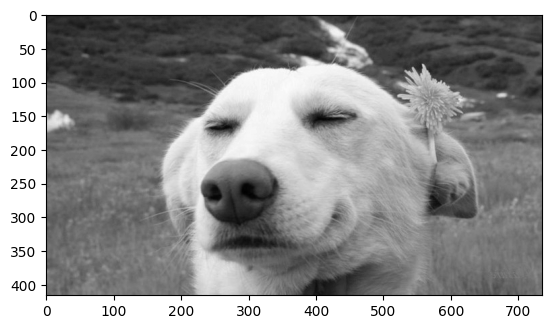

In [ ]:
plt.imshow(img,cmap="gray")

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel) - 10 * log10(mse)
    return psnr

# CASE 1

# Adding Noise in Spatial Domain

In [ ]:
def noise(img,std):
    A = np.eye(img.shape[0])
    n = np.random.normal(0, std, img.shape)
    g = A @ img + n
    return g

In [ ]:
g = noise(img,20)

In [ ]:
g = g.astype(img.dtype)

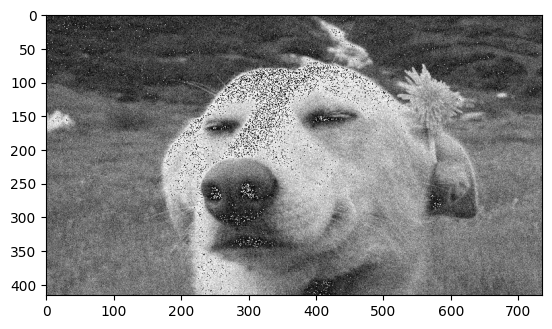

In [ ]:
plt.imshow(g,cmap="gray")

In [ ]:
cv2.PSNR(img,g)

17.558112719457988

# Weiner Filter

In [ ]:
def wiener_filter(img, kernel, K=10):
    dummy = np.copy(img)
    kernel = np.pad(kernel, [(0, dummy.shape[0] - kernel.shape[0]), (0, dummy.shape[1] - kernel.shape[1])], 'constant')
    dummy = fft2(dummy)
    kernel = fft2(kernel)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return np.uint8(dummy)

In [ ]:
kernel = cv2.getGaussianKernel(6,0)
kernel2 = kernel.T * kernel

In [ ]:
kernel2

array([[0.00174026, 0.00625908, 0.01285886, 0.01285886, 0.00625908,
        0.00174026],
       [0.00625908, 0.02251165, 0.04624869, 0.04624869, 0.02251165,
        0.00625908],
       [0.01285886, 0.04624869, 0.09501484, 0.09501484, 0.04624869,
        0.01285886],
       [0.01285886, 0.04624869, 0.09501484, 0.09501484, 0.04624869,
        0.01285886],
       [0.00625908, 0.02251165, 0.04624869, 0.04624869, 0.02251165,
        0.00625908],
       [0.00174026, 0.00625908, 0.01285886, 0.01285886, 0.00625908,
        0.00174026]])

In [ ]:
out = wiener_filter(g, kernel2, 0.1)
cv2.PSNR(img,out)

17.089071464530626

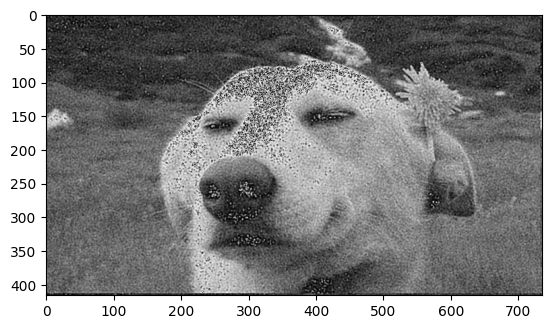

In [ ]:
plt.imshow(out,cmap="gray")

# MAP Estimator

In [ ]:
def huber(x, alpha):
    condition = np.abs(x) <= alpha
    return np.where(condition, 2*x, 2*alpha*np.sign(x))

In [ ]:
def huber_prior(f, alpha):
    grad_x = sobel(f, axis=0)
    grad_y = sobel(f, axis=1)
    return np.sum(huber(grad_x, alpha)) + np.sum(huber(grad_y, alpha))

In [ ]:
def map_cost_function(flat_f, g, alpha, lambda_, image_shape):
    f = flat_f.reshape(image_shape)
    likelihood = np.sum((g - f) ** 2)
    prior = huber_prior(f, alpha)
    return likelihood + lambda_ * prior

In [ ]:
def map_cost_gradient(flat_f, g, alpha, lambda_, image_shape):
    f = flat_f.reshape(image_shape)
    likelihood_grad = -2 * (g - f)
    grad_x = sobel(f, axis=0)
    grad_y = sobel(f, axis=1)
    prior_grad_x = huber(grad_x, alpha)
    prior_grad_y = huber(grad_y, alpha)
    prior_grad = sobel(prior_grad_x, axis=0, mode='constant') + sobel(prior_grad_y, axis=1, mode='constant')
    total_grad = likelihood_grad + lambda_ * prior_grad
    return total_grad.flatten()

In [ ]:
def estimate_map(g, image_shape, alpha, lambda_):
    f_initial = g.flatten()
    result = minimize(
        map_cost_function, f_initial, args=(g, alpha, lambda_, image_shape),
        method='L-BFGS-B', jac=map_cost_gradient, options={'maxiter': 150}
    )
    f_map_estimated = result.x.reshape(image_shape)
    return f_map_estimated

In [ ]:
alpha = 0.5
lambda_ = 0.1
f_map = estimate_map(g, g.shape, alpha, lambda_)

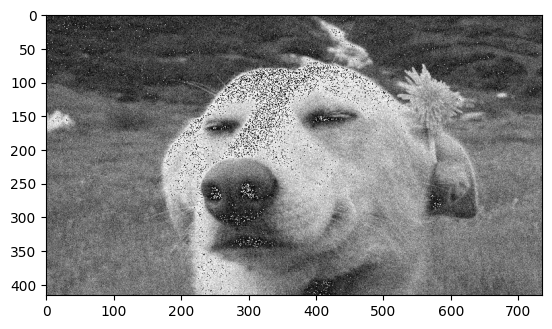

In [ ]:
plt.imshow(f_map,cmap="gray")

In [ ]:
f_map = f_map.astype(img.dtype)

In [ ]:
cv2.PSNR(img,f_map)

17.558112719457988

# CASE 2

# Adding motion blur in spactial domain

In [ ]:
def motion(kernel_size,img):
    h_kernel = np.zeros((kernel_size, kernel_size))
    h_kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    h_kernel /= kernel_size
    blurred_img = cv2.filter2D(img, -1, h_kernel)
    plt.imshow(blurred_img, cmap="gray")
    plt.show()
    return blurred_img

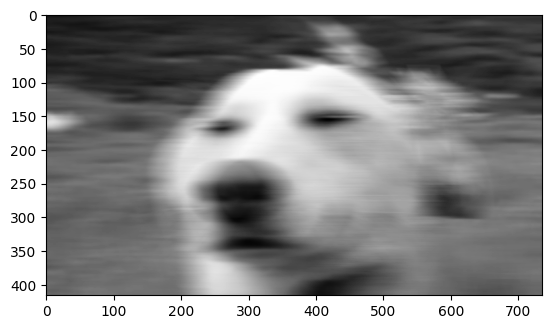

In [ ]:
k = motion(50,img)

In [ ]:
cv2.PSNR(img,k)

24.28442617457376

# Wiener Deblur

In [ ]:
def create_deblur_kernel(size):
    # Create a kernel with the specified size
    kernel = np.zeros((size, size))

    # Fill the kernel with values
    for i in range(size):
        for j in range(size):
            kernel[i, j] = min(i+1, j+1, size-i, size-j)

    # Normalize the kernel
    kernel = kernel / kernel.sum()

    return kernel

In [ ]:
kernel = create_deblur_kernel(5)

In [ ]:
kernel

array([[0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143],
       [0.02857143, 0.05714286, 0.05714286, 0.05714286, 0.02857143],
       [0.02857143, 0.05714286, 0.08571429, 0.05714286, 0.02857143],
       [0.02857143, 0.05714286, 0.05714286, 0.05714286, 0.02857143],
       [0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143]])

In [ ]:
out2 = wiener_filter(k , kernel, K=0.11)

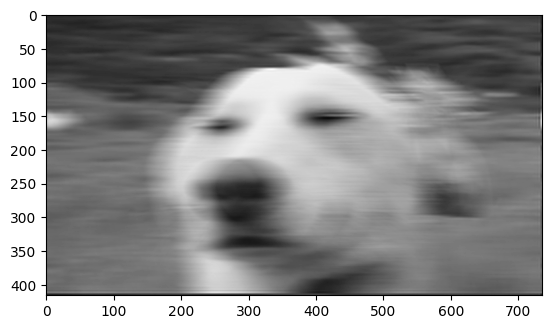

In [ ]:
plt.imshow(out2,cmap="gray")

In [ ]:
cv2.PSNR(img,out2)

21.349397325390793

# MAP estimator (blind deconvolution)

In [ ]:
def convolve_with_kernel(image, kernel):
    return fftconvolve(image, kernel, mode='same')

In [ ]:
def calculate_cost_and_gradient(flat_f, blurred_image, kernel, lambda_, image_shape):
    f = flat_f.reshape(image_shape)
    convolved_f = convolve_with_kernel(f, kernel)
    residual = convolved_f - blurred_image
    fidelity_term = np.sum(residual ** 2)

    f_grad_x, f_grad_y = np.gradient(f)
    regularization_term = lambda_ * (np.sum(f_grad_x**2) + np.sum(f_grad_y**2))

    cost = fidelity_term + regularization_term

    kernel_flipped = np.flipud(np.fliplr(kernel))
    gradient_fidelity = 2 * fftconvolve(residual, kernel_flipped, mode='same')

    laplacian_f = np.gradient(np.gradient(f)[0])[0] + np.gradient(np.gradient(f)[1])[1]
    gradient_regularization = 2 * lambda_ * laplacian_f

    # Total gradient
    gradient = gradient_fidelity + gradient_regularization

    return cost, gradient.flatten()

In [ ]:
def estimate_map(blurred_image, kernel, lambda_, image_shape):
    """Estimate the MAP solution using the cost function and its gradient."""
    f_initial = np.random.rand(*image_shape).flatten()  # Initialize with random values

    # Optimize using the L-BFGS-B method
    result = minimize(
        fun=lambda flat_f: calculate_cost_and_gradient(flat_f, blurred_image, kernel, lambda_, image_shape),
        x0=f_initial,
        method='L-BFGS-B',
        jac=True,
        options={'maxiter': 100, 'disp': True}
    )

    f_map_estimated = result.x.reshape(image_shape)
    return f_map_estimated

In [ ]:
lambda_ = 0.001
image_shape = (416,736)


In [ ]:
f_map = estimate_map(k, kernel, lambda_, image_shape)

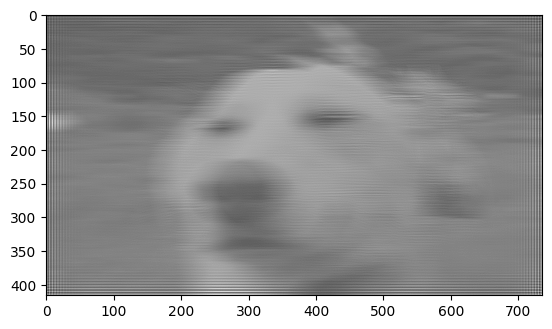

In [ ]:
plt.imshow(f_map,cmap="gray")

In [ ]:
PSNR(img,f_map)

18.29151097565714